In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
n_epochs = 5 # 模型训练5轮
log_interval = 30 #控制打印频率的，设n = 30*batch_size，即n张图后打印一次进度
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 根据设备是否支持GPU来选择硬件 
size = 32 # 对输入图片进行处理，拉伸为32*32的图片，这是为了复刻手写数字识别的神经网络，其输入为32*32的灰度图像
learn_rate = 0.03 # 学习率
momentum = 0.1  # 动量

In [3]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz
from torchvision.datasets import MNIST
transform = transforms.Compose(
    [ transforms.Resize(size), transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))]) # 正则化处理，相当于z-score
trainset = MNIST(root = './', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testset = MNIST(root = './', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=True, num_workers=2)

# classes = ('1', '2', '3', '4', '5', '6', '7', '8', '9', '0')

'wget' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
tar: Error opening archive: Failed to open 'MNIST.tar.gz'


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw



In [4]:
examples = enumerate(testloader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_targets)
print(example_data.shape)

tensor([1, 1, 2, 1, 6, 8, 5, 7, 2, 5, 2, 2, 5, 5, 5, 8, 8, 6, 7, 4, 3, 5, 5, 4,
        5, 6, 5, 6, 1, 3, 3, 1, 5, 8, 8, 1, 1, 4, 5, 0, 7, 2, 4, 4, 4, 0, 5, 0,
        8, 4, 3, 3, 8, 5, 7, 6, 6, 1, 3, 6, 6, 1, 0, 6, 7, 1, 2, 5, 6, 5, 4, 8,
        8, 5, 4, 9, 1, 3, 2, 2, 0, 8, 5, 6, 9, 6, 8, 1, 3, 5, 0, 0, 1, 1, 2, 3,
        4, 1, 6, 2, 6, 0, 6, 4, 7, 5, 9, 0, 0, 1, 8, 1, 7, 5, 3, 1, 9, 4, 4, 8,
        1, 3, 3, 7, 8, 6, 6, 9, 9, 1, 1, 3, 5, 4, 3, 6, 9, 7, 8, 9, 5, 4, 3, 0,
        8, 3, 9, 9, 7, 7, 0, 4, 1, 0, 7, 1, 4, 6, 8, 6, 9, 2, 0, 4, 5, 1, 1, 4,
        8, 1, 1, 2, 7, 0, 6, 0, 4, 2, 7, 7, 6, 4, 7, 1, 5, 0, 2, 8, 5, 7, 1, 4,
        6, 5, 5, 8, 7, 6, 1, 9, 6, 7, 9, 9, 2, 1, 2, 5, 7, 7, 2, 2, 8, 5, 8, 3,
        5, 1, 5, 1, 9, 6, 0, 7, 2, 6, 5, 3, 4, 8, 3, 7, 3, 6, 9, 4, 7, 0, 0, 9,
        2, 8, 7, 7, 8, 4, 3, 0, 6, 1, 7, 0, 1, 2, 2, 1, 1, 9, 7, 4, 3, 4, 0, 6,
        7, 3, 5, 2, 1, 9, 7, 9, 3, 4, 3, 8, 9, 6, 7, 5, 9, 6, 9, 8, 3, 0, 7, 3,
        5, 1, 0, 7, 1, 1, 9, 6, 3, 7, 8,

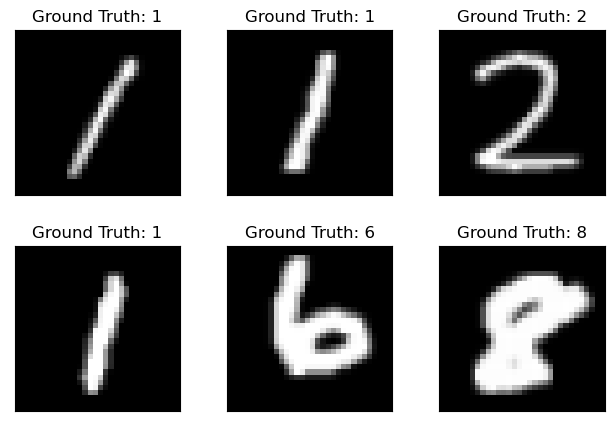

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

In [7]:
network = Net().to(DEVICE)
optimizer = optim.SGD(network.parameters(), lr = learn_rate, momentum=momentum) # 学习率，动量

In [8]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trainloader.dataset) for i in range(n_epochs + 1)] #test_losses为横坐标，test_losses为纵坐标
test_acc = []

In [9]:
def train(epoch, device):
  network.train() # 调用上一步实例化对象network中的方法（该方法包内已经写好）
  for batch_idx, (data, target) in enumerate(trainloader): # 按batch_size为集合对象进行逐个处理
    data, target = data.to(device), target.to(device) # data是图片，target是标签，device是为了有GPU情况下使用GPU加速
    optimizer.zero_grad() # 开始进行BP之前将梯度设置为零，因为PyTorch会在随后的BP中累积梯度
    output = network(data) 
    loss = F.nll_loss(output, target) # 函数全称是negative log likelihood loss，下面博客有详细解释
    # https://blog.csdn.net/weixin_38145317/article/details/103288032
    loss.backward() # 根据误差进行BP
    optimizer.step()
    if batch_idx % log_interval == 0: # 控制输出频率
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(trainloader.dataset),
        100. * batch_idx / len(trainloader), loss.item()))
      train_losses.append(loss.item()) # 记录并储存train loss
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(trainloader.dataset)))

In [10]:
def test(device):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in testloader:
      data, target = data.to(device), target.to(device)
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1] # 找到概率最大的下标，为预测类别
      correct += pred.eq(target.data.view_as(pred)).sum() # x下面都是记录数据用于绘图，不再解释
  test_loss /= len(testloader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(testloader.dataset),
    100. * correct / len(testloader.dataset)))
  test_acc.append(correct / len(testloader.dataset))

In [ ]:
test(DEVICE)
for epoch in range(1, n_epochs + 1):
  train(epoch, DEVICE)
  test(DEVICE)
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue') # train_losses变化曲线
plt.plot(test_counter, test_acc, color='yellow') # test集accuracy变化曲线
plt.scatter(test_counter, test_losses, color='red') # test集loss散点图
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss and test accuarcy')
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_15856\3532451503.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
C:\Users\PC\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3016, Accuracy: 958/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306824
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.304652
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.297939
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.286839
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.283746
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.264546
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.243167
Train Epoch: 1 [13440/60000 (22%)]	Loss: 2.229625
Train Epoch: 1 [15360/60000 (26%)]	Loss: 2.010071
Train Epoch: 1 [17280/60000 (29%)]	Loss: 1.752775
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.362065
Train Epoch: 1 [21120/60000 (35%)]	Loss: 1.142893
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.746820
Train Epoch: 1 [24960/60000 (42%)]	Loss: 1.066595
Train Epoch: 1 [26880/60000 (45%)]	Loss: 0.800186
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.620247
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.485923
Train Epoch: 1 [32640/60000 (54%)]	Loss: 0.579754
Train Epoch: 1 [34560/60000 (58%)]	Loss: 0.407655
Train

In [ ]:
examples = enumerate(testloader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
  example_data, example_targets = example_data.to(DEVICE), example_targets.to(DEVICE)
  output = network(example_data)
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0].cpu().clone().numpy(), cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()